In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
# import necessary libraries
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# set to evaluation mode
model.eval()

# load COCO category names
COCO_CLASS_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
def get_coloured_mask(mask):
  
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(mask).astype(np.uint8)
  g = np.zeros_like(mask).astype(np.uint8)
  b = np.zeros_like(mask).astype(np.uint8)
  r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)

  return coloured_mask

In [ ]:
def get_prediction(img_path, confidence):

  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  print(pred[0]['labels'].numpy().max())
  pred_class = [COCO_CLASS_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]

  return masks, pred_boxes, pred_class

In [ ]:
from matplotlib import patches,  lines

In [ ]:
!pip install opencv-python==4.5.1.48 -i 

In [ ]:
def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):

  masks, boxes, pred_cls = get_prediction(img_path, confidence)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = get_coloured_mask(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    # cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 255, 0), thickness=rect_th)
    # cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)

  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()


8


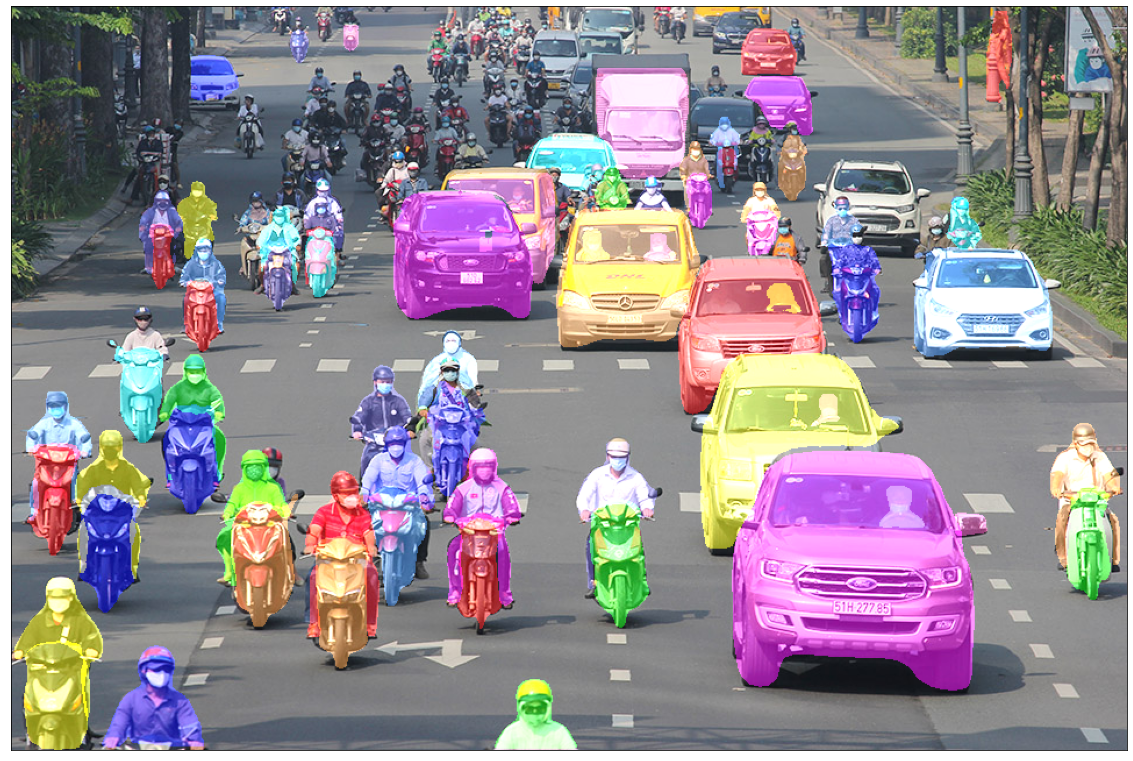

In [ ]:
segment_instance('/content/hcmc-traffic.jpg', confidence=0.7)